# Titanic Survival Prediction

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

## Data Loading

In [2]:
df = pd.read_csv('../input/titanic/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Cleaning

In [4]:
#Check duplicate values
duplicate = df[df.duplicated()]
duplicate

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


No duplicate values found

In [5]:
#Check missing values
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
#Check Percentage of Missing values
df.isnull().sum() * 100 /len(df)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [7]:
#Cabin Feature will be dropped because the missing values is 77% of all data
df_cleaned = df.drop(columns=['Cabin'],axis=1)
#Age Feature will be imputed using Median
df_cleaned['Age'].fillna(df_cleaned['Age'].median(), inplace = True)
#Embarked Feature will be imputed using Mode
df_cleaned['Embarked'].fillna(df_cleaned['Embarked'].mode()[0], inplace = True)


In [8]:
#Recheck the missing values
df_cleaned.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## Logistic Regression

0    549
1    342
Name: Survived, dtype: int64
0    61.616162
1    38.383838
Name: Survived, dtype: float64


<AxesSubplot:ylabel='Survived'>

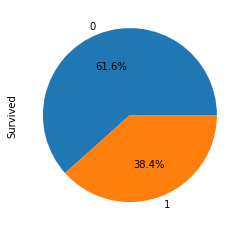

In [9]:
#Explore the Survived Feature
print(df_cleaned.Survived.value_counts())
print(df_cleaned.Survived.value_counts()*100/len(df_cleaned))
df_cleaned.Survived.value_counts().plot(kind = 'pie',autopct='%1.1f%%')


From the total data, there are 38.4% of passengers who survived, and the rest 61.6% did not survive.

   Pclass  Survived  Count  percentage_pclass
0       1         0     80          37.037037
1       1         1    136          62.962963
2       2         0     97          52.717391
3       2         1     87          47.282609
4       3         0    372          75.763747
5       3         1    119          24.236253


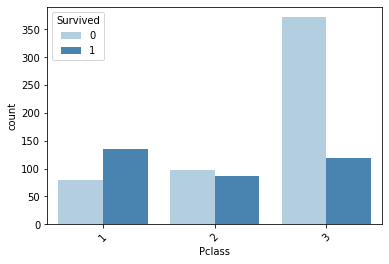

In [10]:
#Explore the Pclass Feature
pclass = df_cleaned.groupby(['Pclass','Survived']).size().reset_index(name='Count')
pclass['percentage_pclass'] = pclass['Count'].div(pclass.groupby('Pclass')['Count'].transform('sum')).mul(100)
print (pclass)
sns.countplot(data=df_cleaned, x="Pclass", hue="Survived" , palette="Blues").tick_params(axis='x', labelrotation=45)
plt.show()


From the Pclass exploration, we gained insight:
1. Class 1 has the highest survival rate, 62% of all the class 1 passengers survived
2. Class 3 has the lowest survival rate, which is only 24% of all the class 3 passengers survived

      Sex  Survived  Count  percentage_sex
0  female         0     81       25.796178
1  female         1    233       74.203822
2    male         0    468       81.109185
3    male         1    109       18.890815


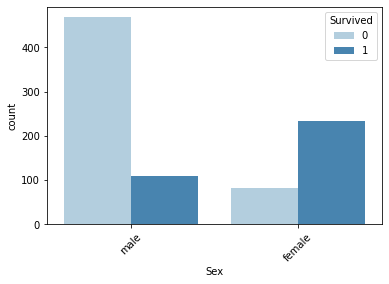

In [11]:
#Explore the Sex Feature
sex = df_cleaned.groupby(['Sex','Survived']).size().reset_index(name='Count')
sex['percentage_sex'] = sex['Count'].div(sex.groupby('Sex')['Count'].transform('sum')).mul(100)
print (sex)
sns.countplot(data=df_cleaned, x="Sex", hue="Survived" , palette="Blues").tick_params(axis='x', labelrotation=45)
plt.show()


From the Sex feature exploration, we gained insight:
1. Female has the highest survival rate, 74% of all the female passengers survived
2. Male has the lowest survival rate, which is only 18% of all the male passengers survived

  Embarked  Survived  Count  percentage_pclass
0        C         0     75          44.642857
1        C         1     93          55.357143
2        Q         0     47          61.038961
3        Q         1     30          38.961039
4        S         0    427          66.099071
5        S         1    219          33.900929


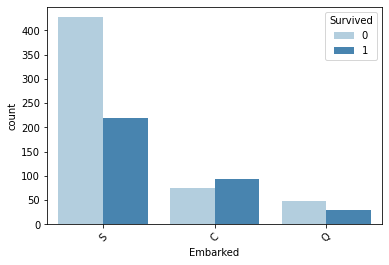

In [12]:
#Explore the Embarked Feature
embark = df_cleaned.groupby(['Embarked','Survived']).size().reset_index(name='Count')
embark['percentage_pclass'] = embark['Count'].div(embark.groupby('Embarked')['Count'].transform('sum')).mul(100)
print (embark)
sns.countplot(data=df_cleaned, x="Embarked", hue="Survived" , palette="Blues").tick_params(axis='x', labelrotation=45)
plt.show()


From the Embarked feature exploration, we gained insight:
1. Passengers who embarked from C the highest survival rate, 55% of all the passengers who embarked from C survived
2. Passengers who embarked from S the lowest survival rate, 33% of all the passengers who embarked from S survived

In [13]:
survived = df_cleaned[df_cleaned["Survived"]==1] 
notsurvived = df_cleaned[df_cleaned["Survived"]==0] 


In [14]:
#Explore Fare Feature
print (survived.Fare.describe())
print (notsurvived.Fare.describe())

count    342.000000
mean      48.395408
std       66.596998
min        0.000000
25%       12.475000
50%       26.000000
75%       57.000000
max      512.329200
Name: Fare, dtype: float64
count    549.000000
mean      22.117887
std       31.388207
min        0.000000
25%        7.854200
50%       10.500000
75%       26.000000
max      263.000000
Name: Fare, dtype: float64


From the Fare feature exploration, we gain insight that the average fare of the survived passengers is more expensive than the average fare of the passengers who did not survive

In [15]:
#Explore Age Feature
print (survived.Age.describe())
print (notsurvived.Age.describe())

count    342.000000
mean      28.291433
std       13.764425
min        0.420000
25%       21.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64
count    549.000000
mean      30.028233
std       12.499986
min        1.000000
25%       23.000000
50%       28.000000
75%       35.000000
max       74.000000
Name: Age, dtype: float64


From the age feature exploration, we conclude that there is no significant difference of age between the passengers who survived and not survived

## Native Bayes

In [16]:
#Check the types of each feature
df_cleaned.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [17]:
#Dropping the Name and Ticket Feature as we will not use it
df_preprocessed = df_cleaned.drop(columns=['Name','Ticket','PassengerId'],axis=1)

In [18]:
#Define categorical features
categorical = ['Sex','Embarked']

In [19]:
#Define the One Hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)

In [20]:
# Aplikasi One Hot Encoder pada data
ohe.fit(df_preprocessed[categorical])
cat_ohe = ohe.transform(df_preprocessed[categorical])

In [21]:
#Making DataFrame from encoded feature
ohe_df = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = categorical))
#Penggabungan original data dengan dataframe encoded
df_encoded = pd.concat([df_preprocessed, ohe_df], axis=1).drop(columns = categorical, axis=1)

In [22]:
#Check the encoded dataframe
df_encoded

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0.0,1.0,0.0,0.0,1.0
887,1,1,19.0,0,0,30.0000,1.0,0.0,0.0,0.0,1.0
888,0,3,28.0,1,2,23.4500,1.0,0.0,0.0,0.0,1.0
889,1,1,26.0,0,0,30.0000,0.0,1.0,1.0,0.0,0.0


In [23]:
#Define X dan Y
y = df_encoded['Survived'].values
X = df_encoded.drop(columns=['Survived'],axis=1).values

In [24]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Decision Tree
We will be using pipeline in this modelling to scale and train the data.
We will also define the hyperparameter to tune the models using GridSearchCV

In [25]:
#Defining Model Pipeline
pipe_lr = Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression(random_state=42))])
pipe_dt = Pipeline([('scl', StandardScaler()), ('clf', DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([('scl', StandardScaler()), ('clf', RandomForestClassifier(random_state=42))])
pipe_knn = Pipeline([('scl', StandardScaler()), ('clf', KNeighborsClassifier())])
pipe_gb = Pipeline([('scl', StandardScaler()), ('clf', GradientBoostingClassifier())])

In [26]:
#Defining Hyperparameter for GridSearch CV
grid_params_lr = [{'clf__penalty': ['l2'],
		'clf__C': [100, 10, 1.0, 0.1, 0.01],
		'clf__solver': ['newton-cg', 'lbfgs', 'liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__n_estimators': [10, 25, 50, 100, 250],
		'clf__max_features': ['auto','sqrt','log2']}]

grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
		'clf__splitter': ['best','random'],
		'clf__max_features': ['auto','sqrt','log2']}]

grid_params_knn = [{'clf__n_neighbors': [1,5,10,25,50],
		'clf__weights': ['uniform','distance'],
		'clf__algorithm': ['auto','ball_tree','kd_tree','brute']}]

grid_params_gb = [{'clf__loss': ['deviance', 'exponential'],
		'clf__learning_rate': [100, 10, 1.0, 0.1, 0.01],
		'clf__n_estimators': [10, 25, 50, 100, 250],
		'clf__max_features': ['auto','sqrt','log2']}]


In [27]:
#Definisi GridSearchCV untuk masing-masing model
gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=10) 
gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=10)
gs_dt = GridSearchCV(estimator=pipe_dt,
			param_grid=grid_params_dt,
			scoring='accuracy',
			cv=10)
gs_knn = GridSearchCV(estimator=pipe_knn,
			param_grid=grid_params_knn,
			scoring='accuracy',
			cv=10)
gs_gb = GridSearchCV(estimator=pipe_gb,
			param_grid=grid_params_gb,
			scoring='accuracy',
			cv=10)

grids = [gs_lr, gs_rf,gs_dt,gs_knn,gs_gb]


In [28]:
grid_dict = {0: 'Logistic Regression', 1: 'Random Forest', 2: 'Decision Tree', 3: 'K Nearest Neighbors',4:'Gradient Boosting',6:'XGBoost'}

## SVM

In [29]:
#Model training with hyperparameter tuning using gridsearchcv
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
	print('\nEstimator: %s' % grid_dict[idx])	
	# Fit grid search	
	gs.fit(X_train, y_train)
	# Best params
	print('Best params: %s' % gs.best_params_)
	# Best training data accuracy
	print('Best training accuracy: %.3f' % gs.best_score_)
	# Predict on test data with best params
	y_pred = gs.predict(X_test)
	# Test data accuracy of model with best params
	print('Test set accuracy for best params: %.3f ' % f1_score(y_test, y_pred))
	# Track best (highest test accuracy) model
	if accuracy_score(y_test, y_pred) > best_acc:
		best_acc = accuracy_score(y_test, y_pred)
		best_gs = gs
		best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}
Best training accuracy: 0.799
Test set accuracy for best params: 0.746 

Estimator: Random Forest
Best params: {'clf__criterion': 'gini', 'clf__max_features': 'auto', 'clf__n_estimators': 100}
Best training accuracy: 0.801
Test set accuracy for best params: 0.759 

Estimator: Decision Tree
Best params: {'clf__criterion': 'entropy', 'clf__max_features': 'auto', 'clf__splitter': 'best'}
Best training accuracy: 0.770
Test set accuracy for best params: 0.745 

Estimator: K Nearest Neighbors
Best params: {'clf__algorithm': 'auto', 'clf__n_neighbors': 10, 'clf__weights': 'uniform'}
Best training accuracy: 0.819
Test set accuracy for best params: 0.741 

Estimator: Gradient Boosting
Best params: {'clf__learning_rate': 0.1, 'clf__loss': 'exponential', 'clf__max_features': 'sqrt', 'clf__n_estimators': 25}
Best training accuracy: 0.834
Test set accuracy

From the model training using gridsearchcv, the model that give highest accuracy is Random Forest
The hyperparameters of the random forest is:
1. Criterion : gini
2. Max Feature : Auto
3. N estimator : 100

## Random Forest

In [30]:
y_pred = best_gs.predict(X_test)

In [31]:
#Construct confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[89 16]
 [19 55]]


In [32]:
#Interpreting confusion matrix
tp = cm[1,1]
tn = cm[0,0]
fp = cm[0,1]
fn = cm[1,0]

print('True Positives(TP) = ', tp)
print('True Negatives(TN) = ', tn)
print('False Positives(FP) = ', fp)
print('False Negatives(FN) = ', fn)

True Positives(TP) =  55
True Negatives(TN) =  89
False Positives(FP) =  16
False Negatives(FN) =  19


In [33]:
# Calculating evaluation metrics
accu = (tp+tn)/(tp+tn+fp+fn)
misclass = (fn+fp)/(tp+tn+fp+fn)
precis = tp/(tp+fp)
sensi = tp/(tp+fn)
speci = tn/(tn+fp)
f1 = 2 * (precis*sensi) / (precis+sensi)


print('Accuracy is ',accu)
print('Misclassification is ',misclass)
print('Precision is ',precis)
print('Sensitivity is ',sensi)
print('Specificity is',speci)
print('F-1 Score is ',f1)

Accuracy is  0.8044692737430168
Misclassification is  0.19553072625698323
Precision is  0.7746478873239436
Sensitivity is  0.7432432432432432
Specificity is 0.8476190476190476
F-1 Score is  0.7586206896551724


In [34]:
print (classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



Interpreting the evaluation metric:
1. Accuracy 84% which means from all the data, this model predicted 84% Positive or Negative correctly
2. Misclassification 16% which means that from all the data, this model predicted 16% Positive or Negative incorrectly
3. Precision 82% which means that from all the predicted positive data, 82% is True Positive.
4. Sensitivity or Recall 78% which means that from all the actual positive data, this model predicted 78% data of True Positive.
5. Specificity 88% which means that from all the actual negative data, this model predicted 88% data of True Negative.
6. F1 Score 80% which means that the average of Precision and Recall is 80%

## Model Inference
Now we will test the model that we selected on new data, which is the test data

In [35]:
#Load the Test Data
dftest = df = pd.read_csv('../input/titanic/test.csv')
dftest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [36]:
duplicatetest = dftest[dftest.duplicated()]
duplicatetest

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [37]:
#Check missing values of test data
dftest.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [38]:
#Dropping the Cabin, Name and Ticket
dftest_cleaned = dftest.drop(columns=['Cabin','Name','Ticket'],axis=1)
#Age and Fare Feature will be imputed using Median
dftest_cleaned['Age'].fillna(dftest_cleaned['Age'].median(), inplace = True)
dftest_cleaned['Fare'].fillna(dftest_cleaned['Fare'].median(), inplace = True)


In [39]:
#Recheck the missing values
dftest_cleaned.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [40]:
cat_test = cat_ohe = ohe.transform(dftest_cleaned[categorical])
ohe_dftest = pd.DataFrame(cat_test, columns = ohe.get_feature_names(input_features = categorical))
dftest_encoded = pd.concat([dftest_cleaned, ohe_dftest], axis=1).drop(columns = categorical, axis=1)

In [41]:
#Check Result of Encoded
dftest_encoded

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,0.0,1.0,0.0,1.0,0.0
1,893,3,47.0,1,0,7.0000,1.0,0.0,0.0,0.0,1.0
2,894,2,62.0,0,0,9.6875,0.0,1.0,0.0,1.0,0.0
3,895,3,27.0,0,0,8.6625,0.0,1.0,0.0,0.0,1.0
4,896,3,22.0,1,1,12.2875,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,27.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0
414,1306,1,39.0,0,0,108.9000,1.0,0.0,1.0,0.0,0.0
415,1307,3,38.5,0,0,7.2500,0.0,1.0,0.0,0.0,1.0
416,1308,3,27.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [42]:
idtest = dftest_encoded['PassengerId'].values
datatest = dftest_encoded.drop(columns = ['PassengerId'], axis=1).values

In [43]:
y_pred_test = best_gs.predict(datatest)

In [44]:
#Create Dataframe that consist of Passenger ID and the Survival Prediction
submission = pd.DataFrame({'PassengerId': idtest,'Survived': y_pred_test})
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [45]:
#Save Submission to csv
submission.to_csv('survival_submission.csv', index=False)